In [1]:
# Keep notebook imports automatically refreshed 
%load_ext autoreload
%autoreload 2

In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

import utils as utils

In [29]:
# Read the CSV with two header rows
lifting_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS9zh4VbXElt5i2a1QZ1Ty19zILKOEynhrJ_V61r0Okae0qVDeETHWRNtkbuM0EjVUXUtiK6MSquVux/pub?gid=0&single=true&output=tsv'
data = utils.PowerliftingData(url=lifting_url, sep='\t', header=None)

In [30]:
body_comp_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS9zh4VbXElt5i2a1QZ1Ty19zILKOEynhrJ_V61r0Okae0qVDeETHWRNtkbuM0EjVUXUtiK6MSquVux/pub?gid=1743601009&single=true&output=tsv'
body_comp = utils.BodyCompositionData(url=body_comp_url, sep='\t')

In [31]:
lift_data = data.split_by_lifts()

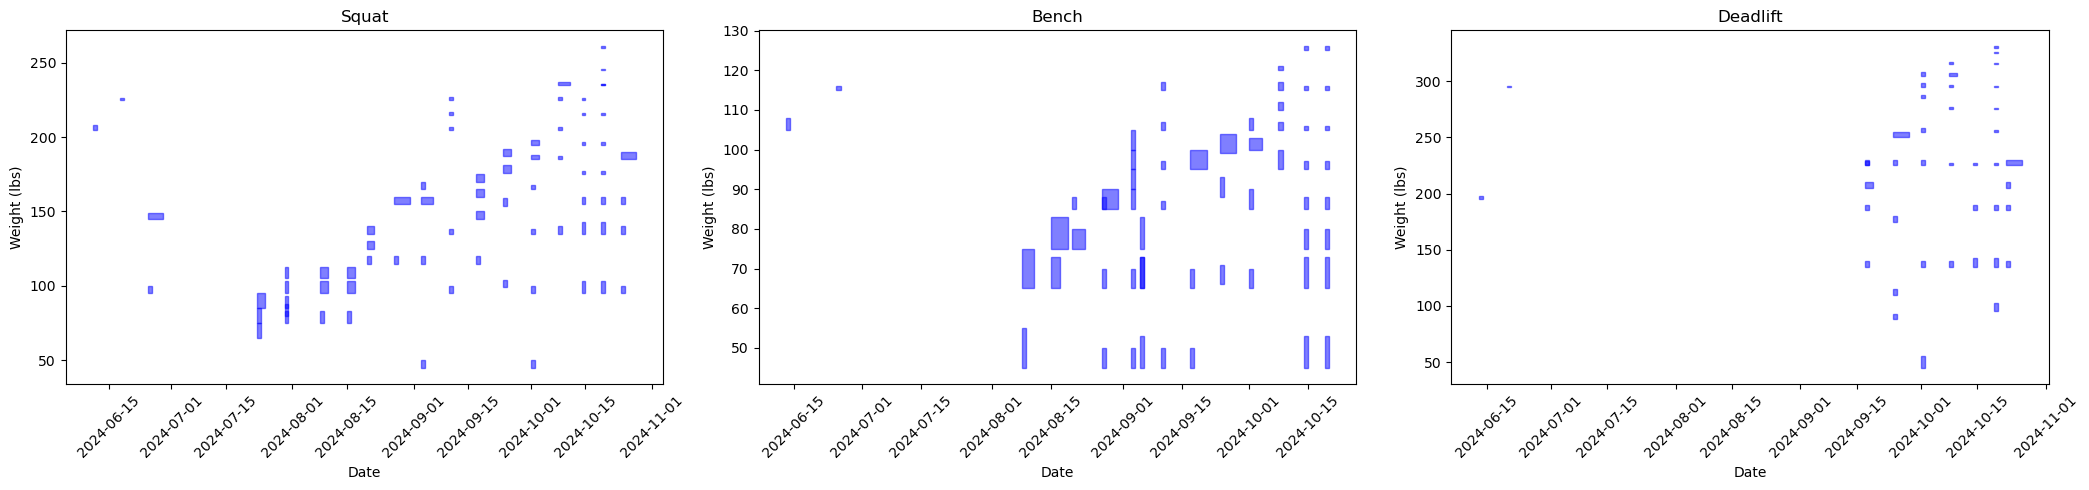

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set y-axis range from 0 to weight max + 30
y_offset = 60

# Make x,1 subplots
fig, axs = plt.subplots(1, len(lift_data), figsize=(7 * len(lift_data), 5))

for (i, lift) in enumerate(lift_data):
    axs[i].set_ylim(0, lift_data[lift][lift + '_Weight'].max() + y_offset)
    utils.plot_rectangles(axs[i], lift_data[lift], lift + '_Weight', 'Date', lift + '_Reps', lift + '_Sets', color='blue', label=lift)
    axs[i].set_title(lift)
    axs[i].set_ylabel('Weight (lbs)')
    axs[i].set_xlabel('Date')

    axs[i].xaxis_date()  # Inform matplotlib that the x-axis contains dates
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


Total change in Weight (lb): -1.20
Total change in Lean Body Mass (lb): 6.90
Total change in Body Fat Mass (lb): -8.00
Total change in PBF (%): -3.70


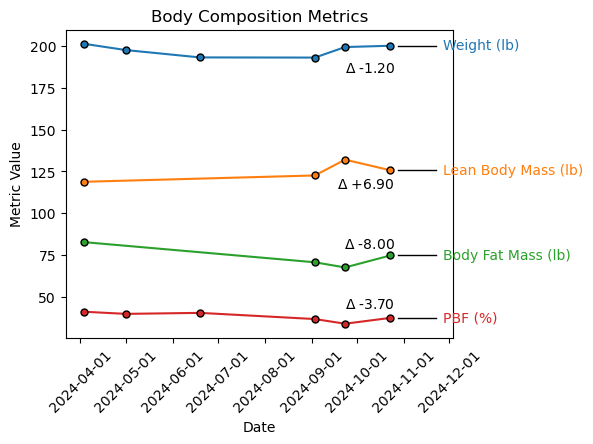

In [61]:
utils.plot_body_composition(body_comp)

In [48]:
lift_rep_max = data.filter_max_weights()

Predicting 1RM for:
Deadlift: 405 lbs
Bench: 142 lbs
Squat: 325 lbs


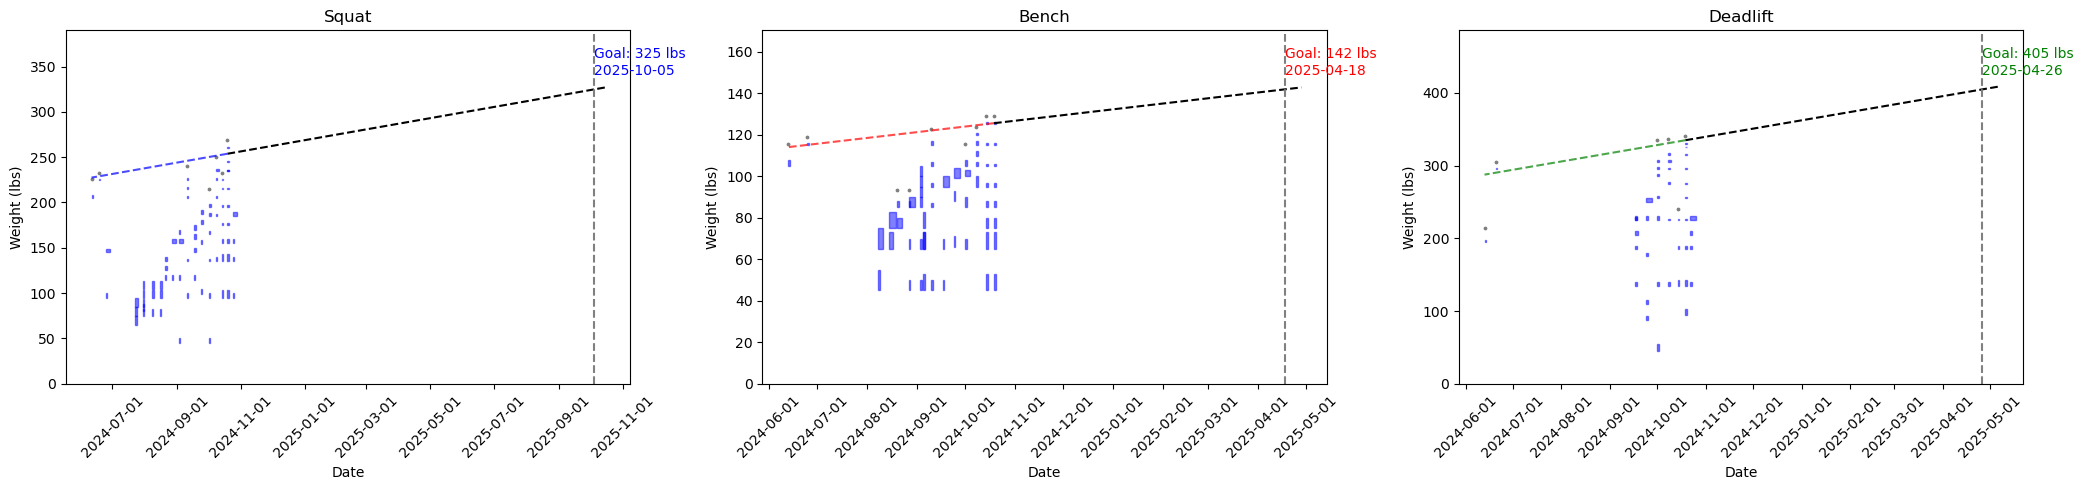

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Goals for each lift
goals = {
    'Squat': 325,
    'Bench': 142,
    'Deadlift': 405
}

print('Predicting 1RM for:')
for lift in lift_rep_max:
    print(f'{lift}: {goals[lift]} lbs')

# Set y-axis range from 0 to weight max + 30
y_offset = 60

# Make x,1 subplots
fig, axs = plt.subplots(1, len(lift_data), figsize=(7 * len(lift_data), 5))

colors = ['blue', 'red', 'green']

for (i, lift) in enumerate(lift_data):
    c = colors[i]
    axs[i].set_ylim(0, lift_data[lift][lift + '_Weight'].max() + y_offset)
    utils.plot_rectangles(axs[i], lift_data[lift], lift + '_Weight', 'Date', lift + '_Reps', lift + '_Sets', color='blue', label=lift)
    utils.predict_future_1rm(axs[i], lift_rep_max[lift], lift, c, goals[lift])

    axs[i].set_title(lift)
    axs[i].set_ylabel('Weight (lbs)')
    axs[i].set_xlabel('Date')

    axs[i].xaxis_date()  # Inform matplotlib that the x-axis contains dates
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()
